In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as kpss
import warnings
warnings.filterwarnings("ignore")

Загрузим данные

In [2]:
data = pd.read_csv('spending_by_day.csv', sep=',', index_col=['data'], parse_dates=['data'], dayfirst=True)
data.tail()

,sum
data,
2019-12-27,1.509453e+07
2019-12-28,1.920698e+07
2019-12-29,1.791994e+07
2019-12-30,1.447355e+07
2019-12-31,9.420428e+06


Проверим целостность

In [3]:
data.isnull().value_counts()

sum  
False    730
dtype: int64

Отрисуем данные

<AxesSubplot:xlabel='data'>

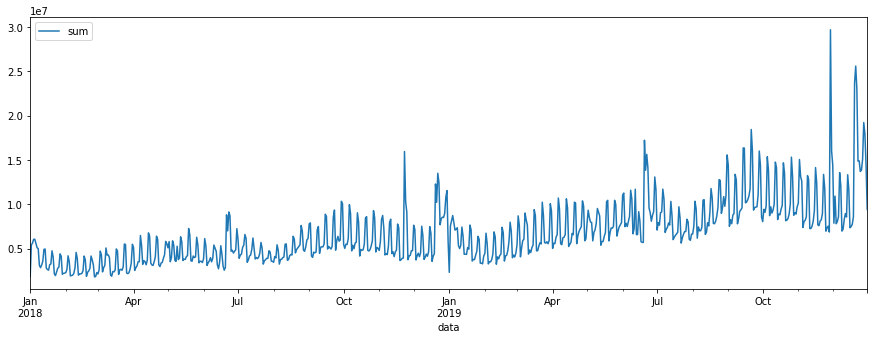

In [4]:
data.plot(figsize=(15,5))

Построим скользящее 7-дневное среднее

<AxesSubplot:xlabel='data'>

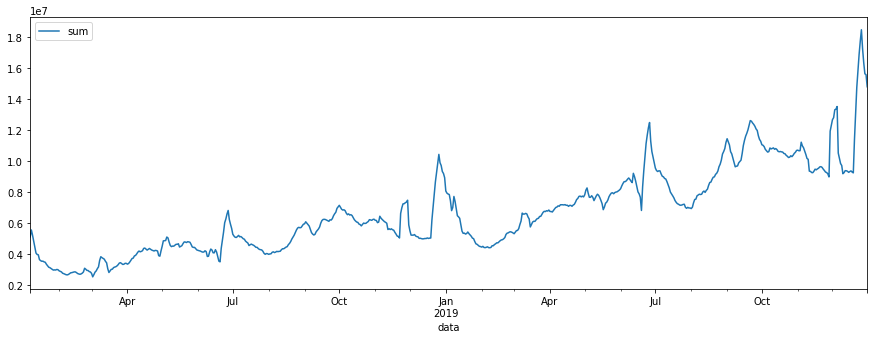

In [5]:
window = 7
data.rolling(window=window).mean().dropna().plot(figsize=(15,5))

Тренд наверняка есть, но нужно будет проверить дифференцированный ряд на стационарность

In [6]:
print('p_value', sm.tsa.stattools.kpss(data, regression='c')[1])

p_value 0.01


По КПСС-критерию ряд стационарный с уровнем значимости 0.01%

Исходный ряд не стационарный по обощенному критерию Дики-Фуллера

In [7]:
test = sm.tsa.adfuller(data)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])

adf:  0.16627083480796218
p-value:  0.9703050977427922
Critical values:  {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}


Значение статистики больше, чем любое из критических значений. Поэтому стационарность ряда отвергается. Нужно дифференцировать ряд

In [22]:
data1diff = data.diff(periods=1).dropna() #Дифференцируем ряд

<AxesSubplot:xlabel='data'>

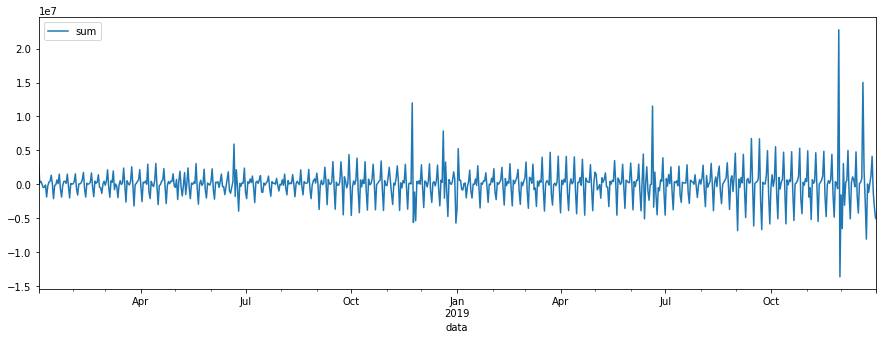

In [23]:
data1diff.plot(figsize=(15,5))

Похоже на стационарный, но необходимо проверить

In [24]:
test = sm.tsa.adfuller(data1diff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])

adf:  -9.289615903346666
p-value:  1.1895034535205232e-15
Critical values:  {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}


Значение статистики теста меньше, чем любое из критических значений. Следовательно, по тесту Дики-Фуллера дифференцированный ряд стационарный, при этом d =1

Посмотрим на автокорреляцию и частичную автокорреляцию, нужно применить сезонное дифференцирование с периодом 7 дней

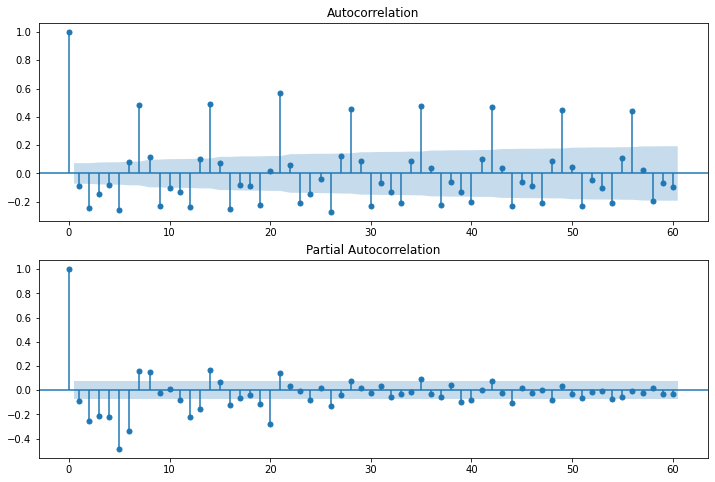

In [65]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data1diff.values.squeeze(), lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data1diff, lags=60, ax=ax2)

In [66]:
data7diff = data.diff(periods=7).dropna()

Применив сезонное дифференцирование хорошо видно, что p=q=6, при этом мы сделали сезонную разницу 1 раз, значит D=1

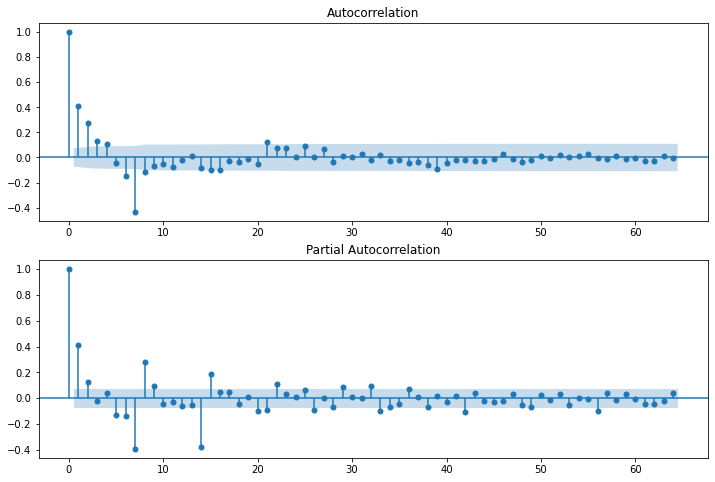

In [74]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data7diff.values.squeeze(), lags=64, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data7diff, lags=64, ax=ax2)

Из графиков по автокорреляции также получилось, что P=6, Q=3

Теперь сравним предсказания модели с реальными значениями ряда

In [80]:
src_data_model = data[:'2019-12-01']
src_data_model
model_sarima = sm.tsa.SARIMAX(src_data_model, order=(6, 1, 6), seasonal_order=(6, 1, 3, 7)).fit(full_output=False, disp=0)

In [81]:
pred_sarima = model_sarima.predict('2019-12-01','2019-12-31', typ='levels')

<AxesSubplot:xlabel='data'>

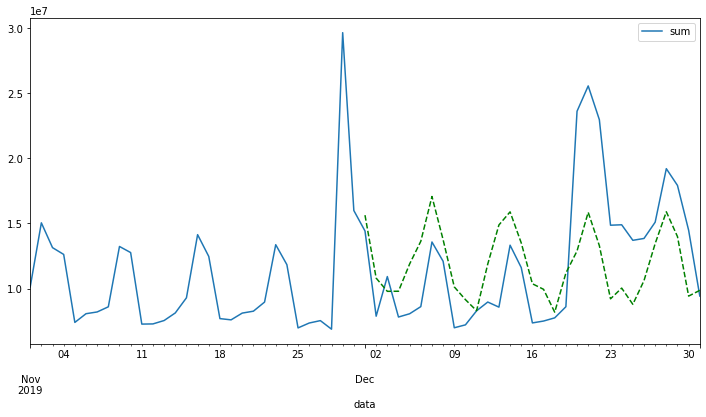

In [82]:
data['2019-11-01':].plot(figsize=(12,6))
pred_sarima.plot(style='g--')

Периодичность похоже что совпадает, но значения не очень близки к реальным

Теперь проверим качество модели и гомоскедастичность остатков

In [85]:
from sklearn.metrics import r2_score

In [91]:
true_values = data['2019-12-01':]
r2 = r2_score(true_values, pred_sarima)
print('R^2: %1.2f' % r2)

R^2: 0.23


R2-score невысокий, модель объясняет 23% дисперсии величины

Построим график остатков модели

<AxesSubplot:xlabel='data'>

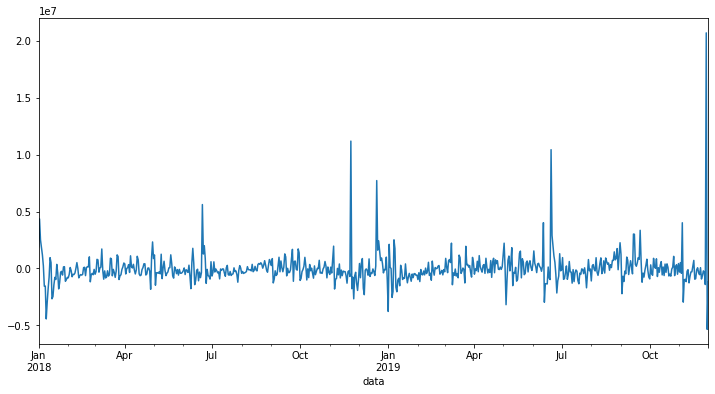

In [98]:
model_sarima.resid.plot(figsize=(12,6))

Визуально остатки кажутся стационарными, но это можно проверить по критерию Льюнга-Бокса

In [92]:
q_test = sm.tsa.stattools.acf(model_sarima.resid, qstat=True)

In [100]:
p_value = pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})
p_value

,Q-stat,p-value
0,0.664311,0.415042
1,0.804000,0.668981
2,0.873619,0.831789
3,0.926149,0.920780
4,1.159293,0.948723
5,1.591706,0.953172
6,1.639664,0.977077
7,2.235475,0.972928
8,2.733887,0.973918
9,2.910993,0.983442


In [103]:
p_value[p_value['Q-stat'] < p_value['p-value']]

,Q-stat,p-value


Все значения Q-статистики больше p-значений, значит остатки являются белым шумом